# 配合ML4 Classification

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

## Generative

In [2]:
def sigma(x, u): # P18
    s1, s2 = x.shape[0:2]
    d = (x - u)
    s = np.zeros(shape=[s2, s2])
    for i in range(s1):
        s += d[i].dot(d[i].T)        
    return s/s1

def Gauss(u, s_inv):
    axis1 = np.linspace(0, 201, 201)
    ax1, ax2 = np.meshgrid(axis1, axis1)
    ax1 = ax1[:, np.newaxis]
    ax2 = ax2[:, np.newaxis]
    x = np.hstack((ax1, ax2)).transpose(0,2,1)[:,:,:, np.newaxis]
    f = ((x - u).transpose(0, 1, 3, 2).dot(s_inv))
    r = (x - u)
    f = f.reshape(-1, f.shape[2], f.shape[3])
    r = r.reshape(-1, r.shape[2], r.shape[3])
    gss = np.array([])
    for i in range(f.shape[0]):
        gss = np.append(gss, f[i].dot(r[i]))
    gss = gss.reshape(int(f.shape[0]**0.5),-1)
    gss = np.exp(-gss*0.5)
    
    return gss

### 資料生成

(0, 200)

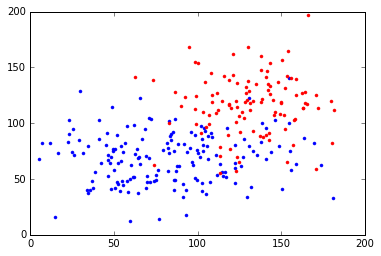

In [3]:
size1 = 170 # x1資料數
size2 = 110 # x2資料數
x11 = np.random.normal(loc=80, scale=40, size=[size1, 1])
x12 = np.random.normal(loc=71, scale=25, size=[size1, 1])
x1 = np.hstack((x11, x12)).reshape(-1, 2, 1)
x21 = np.random.normal(loc= 131, scale=25, size=[size2, 1])
x22 = np.random.normal(loc= 113, scale=25, size=[size2, 1])
x2 = np.hstack((x21, x22)).reshape(-1, 2, 1)

plt.plot(x1[:, 0, :], x1[:, 1, :], '.b')
plt.plot(x2[:, 0, :], x2[:, 1, :], '.r')
plt.xlim(0, 200)
plt.ylim(0, 200)

### 不同Sigma

(0, 200)

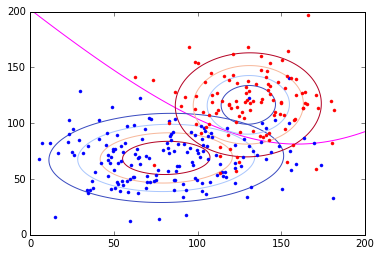

In [4]:
u1 = x1.mean(0)
u2 = x2.mean(0)
sigma1 = sigma(x1, u1)
sigma2 = sigma(x2, u2)
sigma1_inv = np.linalg.inv(sigma1) # 逆矩陣
sigma2_inv = np.linalg.inv(sigma2) # 逆矩陣
gss1 = Gauss(u1, sigma1_inv)
gss2 = Gauss(u2, sigma2_inv)

all_size = size1 + size2 
b = gss1 * size1/ all_size
r = gss2 * size2/ all_size
plt.contour(r/(b+r), 1, extent=[0, 200, 0, 200], cmap=plt.cm.cool_r)
plt.contour(gss1, 5, extent=[0, 200, 0, 200], cmap=plt.cm.coolwarm)
plt.contour(gss2, 5, extent=[0, 200, 0, 200], cmap=plt.cm.coolwarm_r)
plt.plot(x1[:, 0, :], x1[:, 1, :], '.b')
plt.plot(x2[:, 0, :], x2[:, 1, :], '.r')
plt.xlim(0, 200)
plt.ylim(0, 200)

### 共用sigma

(0, 200)

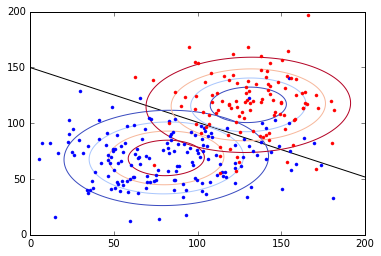

In [5]:
sigma = ((sigma1 * size1) + (sigma2 * size2)) / all_size
sigma_inv = np.linalg.inv(sigma)
gss1 = Gauss(u1, sigma_inv)
gss2 = Gauss(u2, sigma_inv)
bp = gss1 * size1/ all_size
rp = gss2 * size2/ all_size

plt.contour(rp/(bp+rp), 1, extent=[0, 200, 0, 200], cmap=plt.cm.bone)
plt.contour(gss1, 5, extent=[0, 200, 0, 200], cmap=plt.cm.coolwarm)
plt.contour(gss2, 5, extent=[0, 200, 0, 200], cmap=plt.cm.coolwarm_r)
plt.plot(x1[:, 0, :], x1[:, 1, :], '.b')
plt.plot(x2[:, 0, :], x2[:, 1, :], '.r')
plt.xlim(0, 200)
plt.ylim(0, 200)

## Discriminative

### 1 layer  線性分類

In [6]:
x1 = x1.reshape(size1, -1)
x2 = x2.reshape(size2, -1)
x = np.vstack((x1, x2)) #資料整合起來train
x_train = (x/x.max()).astype(np.float32) # x 資料處理過 0~1  另外TF需要float32資料格式
t_train = np.zeros_like(x_train, dtype=np.int)
t_train[0:size1, 0], t_train[size1:all_size, 1] = 1, 1

In [7]:
W = tf.Variable(name='W', initial_value=tf.random_normal(shape=[2, 2], stddev=(2.0/2)**0.5))
b = tf.Variable(name='b', initial_value=tf.random_normal(shape=[2], stddev=(2.0/2)**0.5))

Wx_plus_b = tf.add(tf.matmul(x_train, W), b)
z = tf.sigmoid(Wx_plus_b)
y = tf.nn.softmax(z)

loss = -tf.reduce_mean(tf.reduce_sum((t_train * tf.log(tf.clip_by_value(y, 1e-16, 1))), axis=1))
train_way = tf.train.GradientDescentOptimizer(learning_rate=0.05)
train_step = train_way.minimize(loss)

# tf.cast() 改變資料型態 np.astype change dtype
acc = tf.cast(tf.equal(tf.argmax(y, axis=1), tf.argmax(t_train, axis=1)), tf.float32)
accuracy = tf.reduce_mean(acc, name='accuracy')

sess = tf.Session()
sess.run(tf.global_variables_initializer()) # 變數初始化

In [8]:
for i_ in range(20001):

    sess.run(train_step)
    
    if i_ % 5000 == 0:
    # Accuracy test data
        acc = sess.run(accuracy)*100
        los = sess.run(loss)
        print('%5d  train:%.2f  loss:%.2f'%(i_, acc, los))
line = sess.run(y).argmax(1)
#sess.close()

    0  train:56.07  loss:0.71
 5000  train:60.71  loss:0.62
10000  train:61.43  loss:0.59
15000  train:87.86  loss:0.54
20000  train:89.64  loss:0.51


(0, 200)

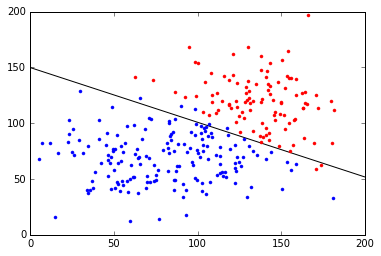

In [9]:
x1 = x[line==0]
x2 = x[line==1]
plt.contour(rp/(bp+rp), 1, extent=[0, 200, 0, 200], cmap=plt.cm.bone) # Generative 分類線
plt.plot(x1[:, 0], x1[:, 1], '.b')
plt.plot(x2[:, 0], x2[:, 1], '.r')
plt.xlim(0, 200)
plt.ylim(0, 200)

### 2 Layer 非線性分類(有機會...)~

(-0.2, 1.2)

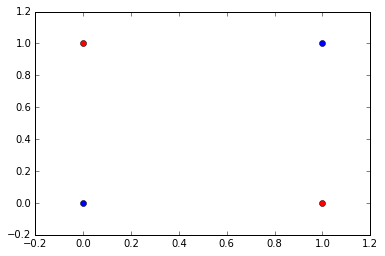

In [10]:
a = np.array([[0, 0], [1, 1]])
b = np.array([[1, 0], [0, 1]])
x = np.array([[0, 0], [1, 1], [1, 0], [0, 1]]).astype(np.float32)
t = np.array([[1, 0], [1, 0], [0, 1], [0, 1]])
plt.plot(a[:, 0], a[:, 1], 'ob')
plt.plot(b[:, 0], b[:, 1], 'or')
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)

In [11]:
W1 = tf.Variable(name='W1', initial_value=tf.random_normal(shape=[2, 2], stddev=(2.0/2)**0.5, seed=47))
b1 = tf.Variable(name='b1', initial_value=tf.random_normal(shape=[2], stddev=(2.0/2)**0.5, seed=47))
W2 = tf.Variable(name='W2', initial_value=tf.random_normal(shape=[2, 2], stddev=(2.0/2)**0.5, seed=47))
b2 = tf.Variable(name='b2', initial_value=tf.random_normal(shape=[2], stddev=(2.0/2)**0.5, seed=47))
x_train = tf.placeholder(tf.float32, shape=[None, 2])
W1x_plus_b1 = tf.add(tf.matmul(x_train, W1), b1)
z1 = tf.sigmoid(W1x_plus_b1)
W2z1_plus_b2 = tf.add(tf.matmul(z1, W2), b2)
z2 = tf.sigmoid(W2z1_plus_b2)
y = tf.nn.softmax(z2)

loss = -tf.reduce_mean(tf.reduce_sum((t * tf.log(tf.clip_by_value(y, 1e-16, 1))), axis=1))
train_way = tf.train.MomentumOptimizer(learning_rate=0.1, momentum=0.9)
train_step = train_way.minimize(loss)

# tf.cast() 改變資料型態 np.astype change dtype
acc = tf.cast(tf.equal(tf.argmax(y, axis=1), tf.argmax(t, axis=1)), tf.float32)
accuracy = tf.reduce_mean(acc, name='accuracy')

sess = tf.Session()
sess.run(tf.global_variables_initializer()) # 變數初始化

In [12]:
feed_dict = {x_train:x}
for i_ in range(2001):
    sess.run(train_step, feed_dict=feed_dict)
    if i_ % 200 == 0:
    # Accuracy test data
        acc, los = sess.run([accuracy, loss], feed_dict=feed_dict)
        print('%5d  train:%.2f  loss:%.2f'%(i_, acc*100, los))
line = sess.run(y, feed_dict=feed_dict).argmax(1)
#sess.close()

    0  train:50.00  loss:0.71
  200  train:50.00  loss:0.69
  400  train:75.00  loss:0.68
  600  train:75.00  loss:0.64
  800  train:75.00  loss:0.59
 1000  train:75.00  loss:0.58
 1200  train:75.00  loss:0.57
 1400  train:75.00  loss:0.56
 1600  train:75.00  loss:0.54
 1800  train:75.00  loss:0.48
 2000  train:100.00  loss:0.39


In [13]:
p = 51
ax = np.linspace(-0.2, 1.2, p)
ax1, ax2 = np.meshgrid(ax, ax)
ax1 = ax1[:, np.newaxis]
ax2 = ax2[:, np.newaxis]
ax = np.hstack((ax1, ax2)).transpose(0,2,1)

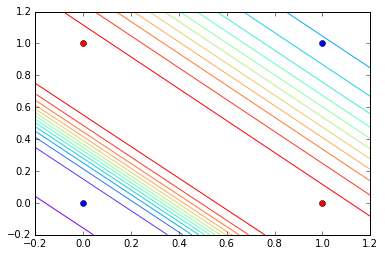

In [14]:
a = x[line==0]
b = x[line==1]
plt.plot(a[:, 0], a[:, 1], 'ob')
plt.plot(b[:, 0], b[:, 1], 'or')
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)

ll = sess.run(y, feed_dict={x_train:ax.reshape(-1, 2)})[:, 0].reshape(p, p)
plt.contour(ll, 15, extent=[-0.2, 1.2, -0.2, 1.2], cmap=plt.cm.rainbow_r)